# Problem statement:
- To build a CNN based model which can accurately detect melanoma.
- Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Data Reading / Data Understanding

## Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Conv2D, Dropout, Dense, MaxPooling2D, BatchNormalization
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing Skin Cancer Data

In [5]:
# Root directory
root_path = '/content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/'

train_path = root_path + "Train/"
test_path = root_path + "Test/"

# Defining the path for train and test images
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118



This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# Dataset creation

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
              data_dir_train,
              seed = 123,
              validation_split = 0.2,
              subset = 'training',
              image_size = (img_height, img_width), # resizing the image
              batch_size = batch_size
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
             data_dir_train,
             seed = 123,
             validation_split = 0.2,
             subset = 'validation',
             image_size = (img_height, img_width), # resizing the image
             batch_size = batch_size
          )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset Visualisation

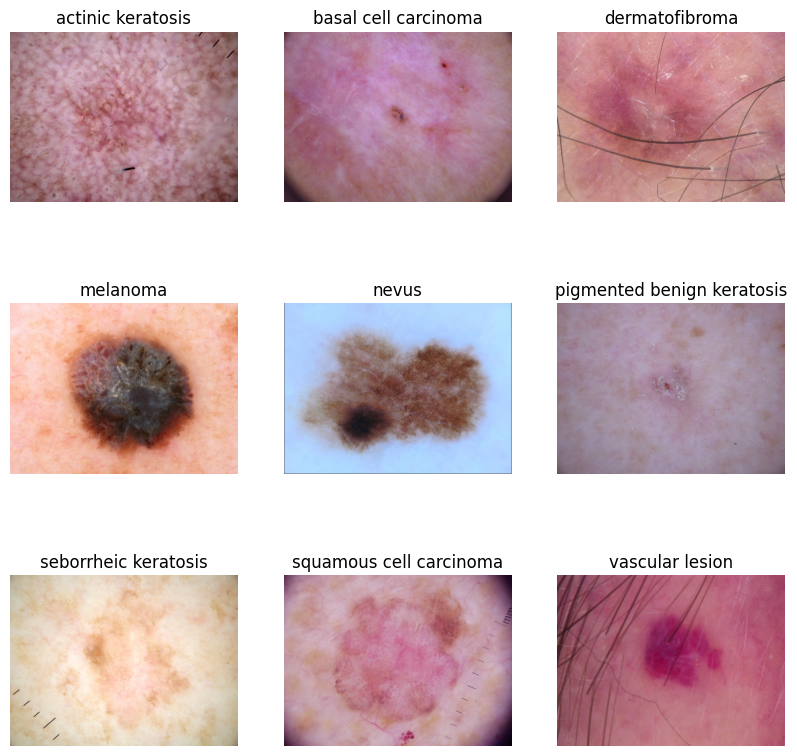

In [11]:
plt.figure(figsize=(10,10))

for lesion_type in range(class_number):
    class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
    lesion_imgs = list(class_path)
    img = PIL.Image.open(str(lesion_imgs[0]))
    ax = plt.subplot(3,3, lesion_type+1)
    plt.imshow(img)
    plt.title(class_names[lesion_type])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
def create_cached_ds(train, val):
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  train_cached = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_cached = val.cache().prefetch(buffer_size=AUTOTUNE)

  return (train_cached, val_cached)

# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_ds_cached = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds_cached = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
(train_ds_cached, val_ds_cached) = create_cached_ds(train_ds, val_ds)

# Model Building & Training

## Creating a model

In [14]:
model = Sequential(
    [
      layers.experimental.preprocessing.Rescaling(1./255,
                                                  input_shape = (
                                                      img_height,
                                                      img_width,
                                                      3
                                                    )
                                                  ),

      Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),


      Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Flatten(),
      Dense(1024, activation='relu'),
      Dropout(0.5),

      Dense(9, activation='softmax')
    ]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

## Compiling the model

In [15]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Training the model

In [16]:
epochs = 20
model_history = model.fit(
  train_ds_cached,
  validation_data = val_ds_cached,
  epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 428s 2s/step - loss: 2.0791 - accuracy: 0.1881 - val_loss: 2.0427 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 2s 34ms/step - loss: 2.0288 - accuracy: 0.1948 - val_loss: 2.0268 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 2.0226 - accuracy: 0.1998 - val_loss: 1.9992 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.9765 - accuracy: 0.2070 - val_loss: 1.9054 - val_accuracy: 0.2841
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 1.8439 - accuracy: 0.3019 - val_loss: 1.8222 - val_accuracy: 0.3154
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 1.7228 - accuracy: 0.3504 - val_loss: 1.6567 - val_accuracy: 0.3848
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6519 - accuracy: 0.3895 - val_loss: 1.5813 - val_accuracy: 0.4541
Epoch 8/20
56

## Visualising the model

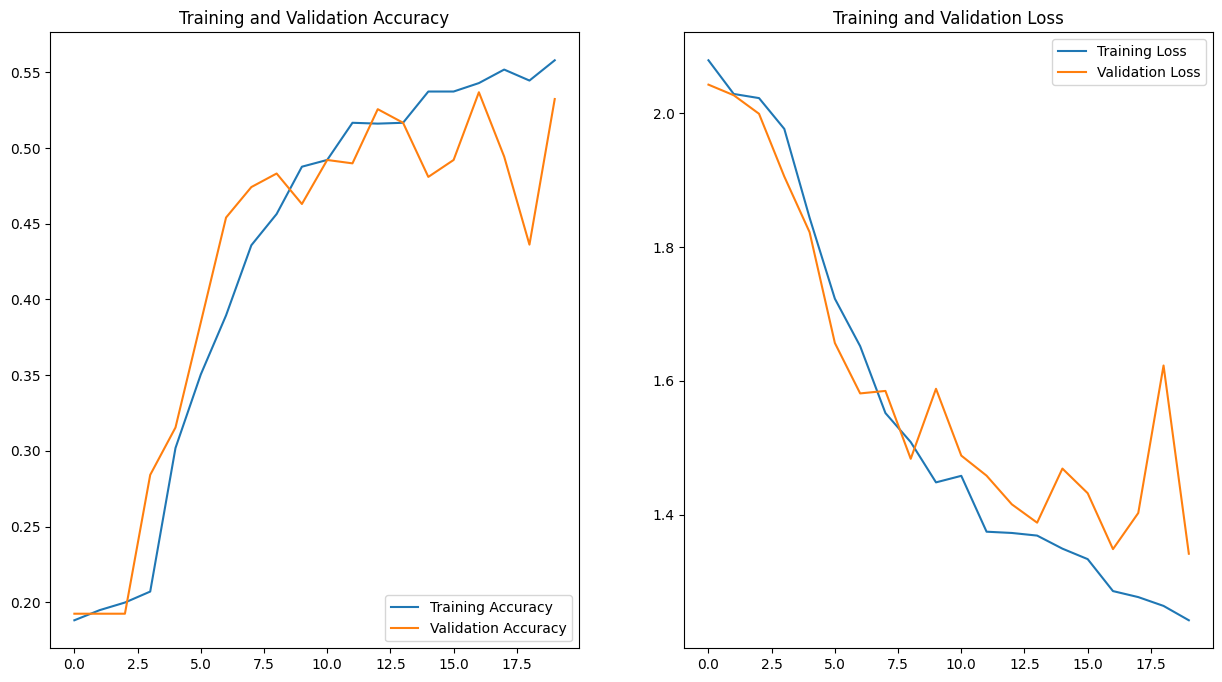

In [17]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the plots above, the training accuracy as well as validation accuracy is increasing linearly over time, however, the accuracy is not up to the par.

# Data Augmentation

In [18]:
data_augmentation = keras.Sequential(
                      [
                        layers.RandomFlip("horizontal_and_vertical",
                                          input_shape=(img_height,
                                                      img_width,
                                                      3)
                                          ),
                        layers.RandomRotation(0.2),
                        layers.RandomZoom(0.2),
                        layers.RandomBrightness(0.1),
                      ]
                    )

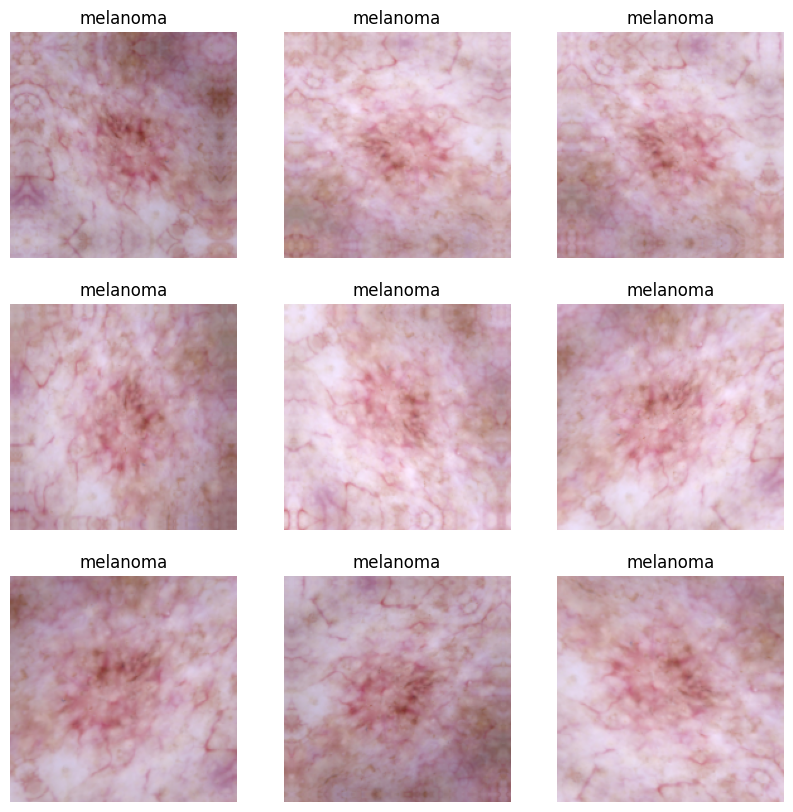

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_cached.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[1]])
    plt.axis("off")

# Model Building & Training - Augmentation
- Using data augmentation strategy to check for overfitting/underfitting.



## Creating model consisting data augmentation

In [20]:
model_aug = Sequential(
    [
      layers.experimental.preprocessing.Rescaling(1./255,
                                                  input_shape = (
                                                      img_height,
                                                      img_width,
                                                      3
                                                    )
                                                  ),
      data_augmentation,

      Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),


      Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Flatten(),
      Dense(1024, activation='relu'),
      Dropout(0.5),

      Dense(9, activation='softmax')
    ]
)

model_aug.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

## Compiling the model

In [21]:
model_aug.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
epochs = 20
model_aug_history = model_aug.fit(
  train_ds_cached,
  validation_data = val_ds_cached,
  epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 5s 40ms/step - loss: 2.4493 - accuracy: 0.1953 - val_loss: 2.0309 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 2.0245 - accuracy: 0.1881 - val_loss: 2.0270 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 2s 38ms/step - loss: 2.0217 - accuracy: 0.1802 - val_loss: 2.0265 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 2s 37ms/step - loss: 2.0168 - accuracy: 0.2015 - val_loss: 2.0229 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 2s 36ms/step - loss: 2.0225 - accuracy: 0.2070 - val_loss: 2.0216 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 2s 36ms/step - loss: 2.0265 - accuracy: 0.1920 - val_loss: 2.0241 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 2s 36ms/step - loss: 2.0194 - accuracy: 0.1981 - val_loss: 2.0230 - val_accuracy: 0.2058
Epoch 8/20
56

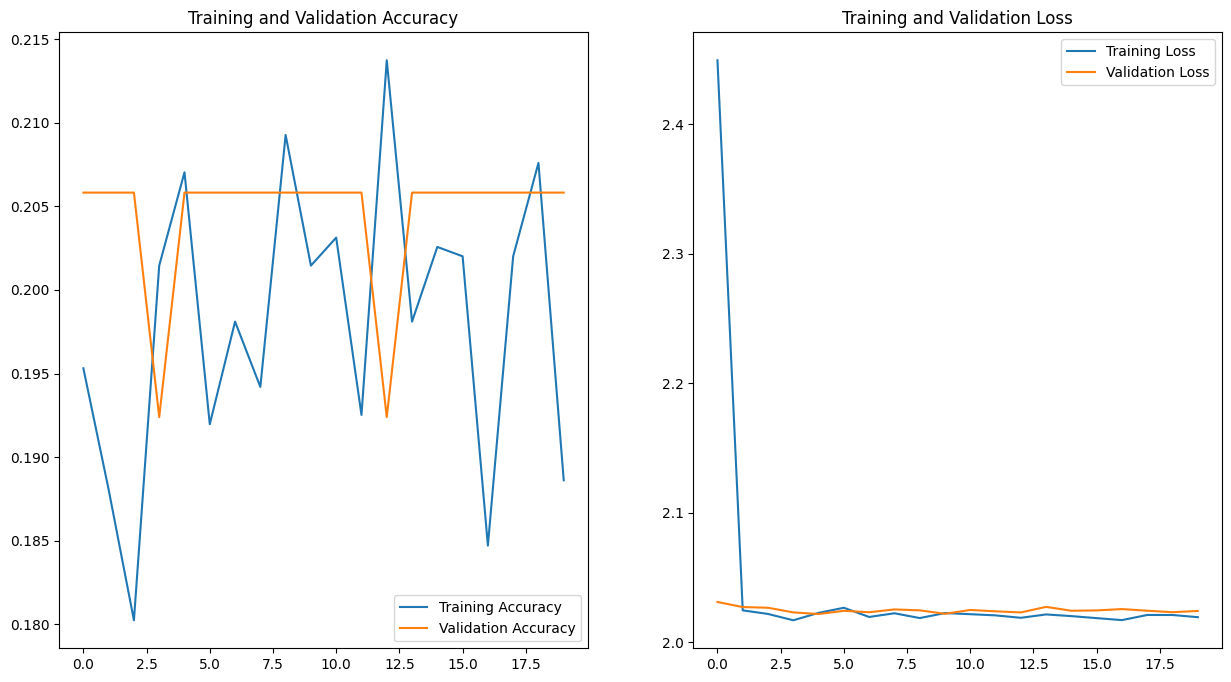

In [23]:
acc = model_aug_history.history['accuracy']
val_acc = model_aug_history.history['val_accuracy']

loss = model_aug_history.history['loss']
val_loss = model_aug_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model with augmentation layers does not perform better on the training data, actually performing significantly worse.

# Class Distribution

In [24]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [25]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Melanoma Detection/Ski...,seborrheic keratosis
1,/content/gdrive/MyDrive/Melanoma Detection/Ski...,seborrheic keratosis
2,/content/gdrive/MyDrive/Melanoma Detection/Ski...,seborrheic keratosis
3,/content/gdrive/MyDrive/Melanoma Detection/Ski...,seborrheic keratosis
4,/content/gdrive/MyDrive/Melanoma Detection/Ski...,seborrheic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Melanoma Detection/Ski...,basal cell carcinoma
2235,/content/gdrive/MyDrive/Melanoma Detection/Ski...,basal cell carcinoma
2236,/content/gdrive/MyDrive/Melanoma Detection/Ski...,basal cell carcinoma
2237,/content/gdrive/MyDrive/Melanoma Detection/Ski...,basal cell carcinoma


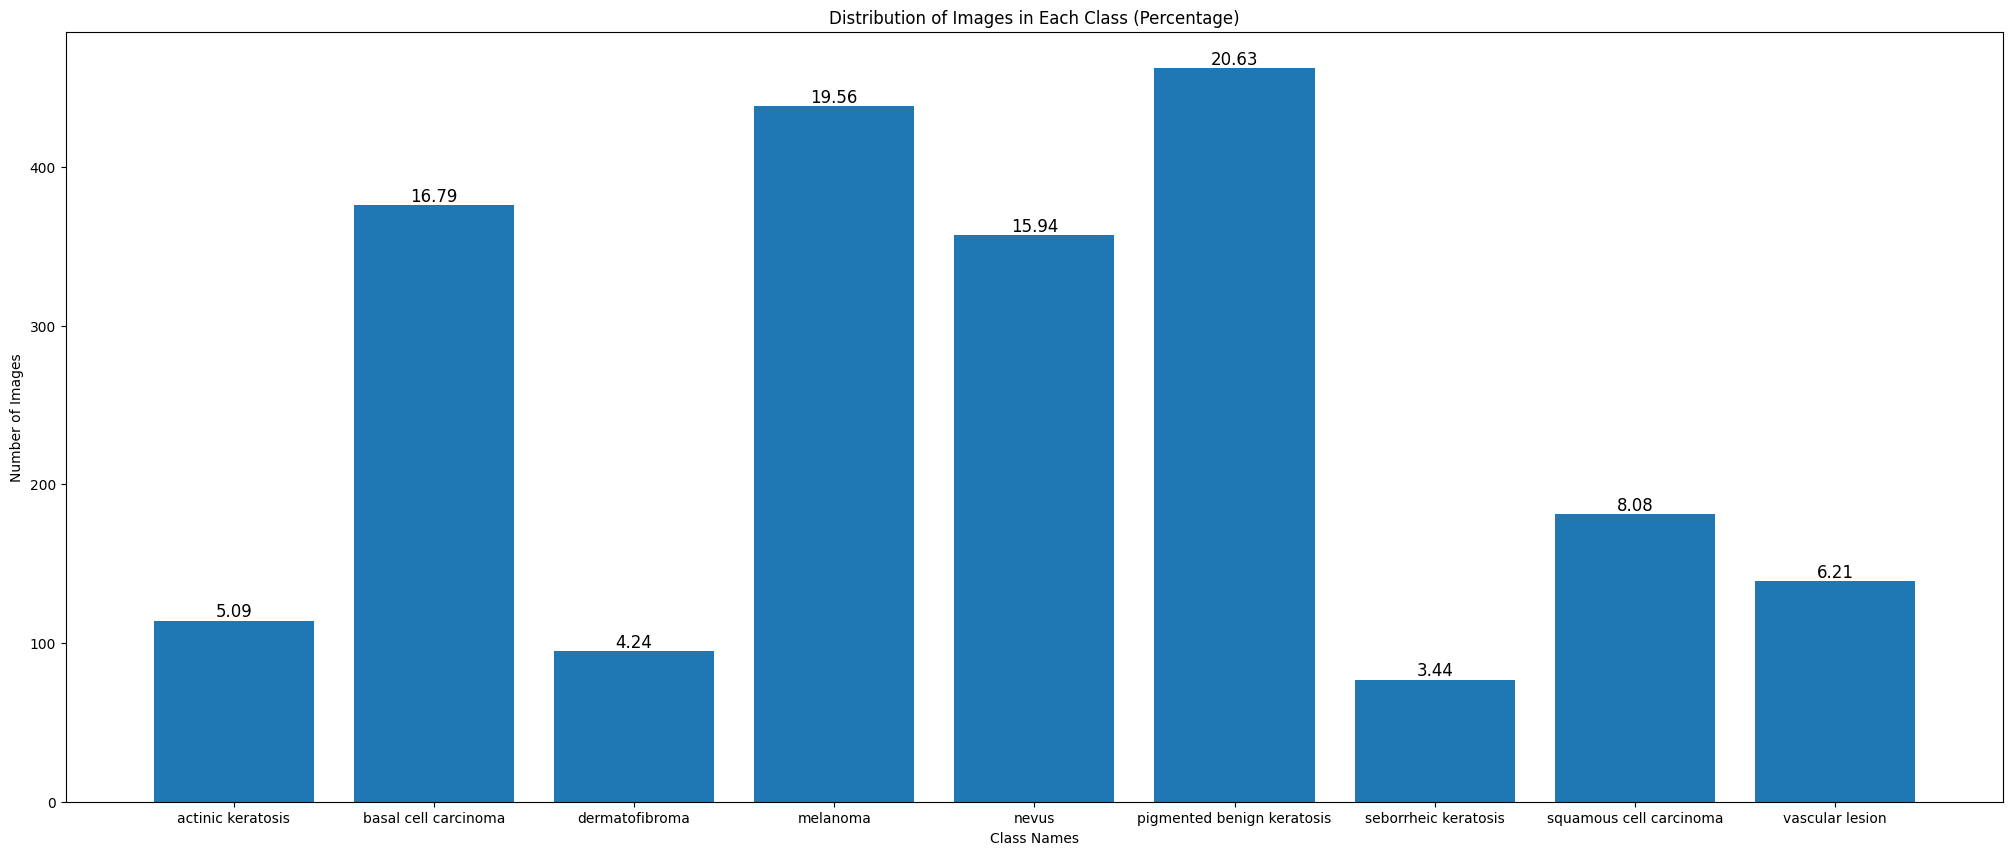

actinic keratosis              92
basal cell carcinoma          309
dermatofibroma                 77
melanoma                      352
nevus                         277
pigmented benign keratosis    370
seborrheic keratosis           58
squamous cell carcinoma       142
vascular lesion               115
dtype: int64


In [26]:
count = [len(list(data_dir_train.glob(f'{class_name}/*.jpg'))) for class_name in train_ds.class_names]

total_samples = sum(count)
percentages = [count[i] / total_samples * 100 for i in range(len(count))]

plt.figure(figsize=(25, 10))
bars = plt.bar(train_ds.class_names, count)

# Annotating each bar with the percentage value
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(percentage, 2), ha='center', va='bottom', fontsize=12)

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class (Percentage)')
plt.show()

dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# absolute count
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Seborrheic keratosis has the least number of samples at 58
#### - Which classes dominate the data in terms proportionate number of samples?
The classes with the most samples are: pigmented benign keratosis(370), melanoma(352), basal cell carcinoma(309), nevus(277). Clearly the classes "pigmented benign keratosis" and "melanoma" dominate the data.

# Handling Class Imbalances

#### To rectify the class imbalance, using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

In [28]:
import Augmentor

for i in class_names:
    src_directory = train_path + i
    op_directory = train_path + i + '/augmented'
    p = Augmentor.Pipeline(src_directory, output_directory=op_directory)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.



Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A74BB9FB880>: 100%|██████████| 500/500 [00:21<00:00, 23.02 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A74F0318730>: 100%|██████████| 500/500 [00:23<00:00, 20.96 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/augmented.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A74BB983C10>: 100%|██████████| 500/500 [00:23<00:00, 21.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/augmented.

Processing <PIL.Image.Image image mode=RGB size=2304x1536 at 0x7A74F5D238E0>: 100%|██████████| 500/500 [01:21<00:00,  6.10 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/augmented.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7A74AA974430>: 100%|██████████| 500/500 [01:27<00:00,  5.72 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A74F0377160>: 100%|██████████| 500/500 [00:18<00:00, 26.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/augmented.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A74BB9F7D30>: 100%|██████████| 500/500 [00:43<00:00, 11.52 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/augmented.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A74F4170220>: 100%|██████████| 500/500 [00:19<00:00, 25.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/augmented.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A74F0153910>: 100%|██████████| 500/500 [00:21<00:00, 22.74 Samples/s]


Augmentor has stored the augmented images in the 'augmented' sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/augmented/*.jpg')))
print(image_count_train)

4500


In [31]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("No.of Actual Images : ", len(path_list))
print("No.of Lesion Types : ", len(lesion_list))

# Relative to folder - "Skin cancer ISIC The International Skin Imaging Collaboration"
paths_to_show = ["/".join(y.split("/")[-3:]) for y in path_list]

df_dict_original = {'Path': paths_to_show, 'Label': lesion_list,}
original_df = pd.DataFrame(df_dict_original)
print(original_df)


No.of Actual Images :  2239
No.of Lesion Types :  2239
                                             Path                 Label
0     Train/seborrheic keratosis/ISIC_0010878.jpg  seborrheic keratosis
1     Train/seborrheic keratosis/ISIC_0010852.jpg  seborrheic keratosis
2     Train/seborrheic keratosis/ISIC_0010872.jpg  seborrheic keratosis
3     Train/seborrheic keratosis/ISIC_0010862.jpg  seborrheic keratosis
4     Train/seborrheic keratosis/ISIC_0010898.jpg  seborrheic keratosis
...                                           ...                   ...
2234  Train/basal cell carcinoma/ISIC_0031513.jpg  basal cell carcinoma
2235  Train/basal cell carcinoma/ISIC_0031056.jpg  basal cell carcinoma
2236  Train/basal cell carcinoma/ISIC_0031063.jpg  basal cell carcinoma
2237  Train/basal cell carcinoma/ISIC_0031175.jpg  basal cell carcinoma
2238  Train/basal cell carcinoma/ISIC_0031378.jpg  basal cell carcinoma

[2239 rows x 2 columns]


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'augmented', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', 'augmented', '*.jpg'))]


In [33]:
desired_paths_new = ["/".join(y.split("/")[-4:]) for y in path_list_new]

df_dict_new = {'Path': desired_paths_new, 'Label': lesion_list_new,}
df_2 = pd.DataFrame(df_dict_new)
print(df_2)

                                                   Path                 Label
0     Train/seborrheic keratosis/augmented/seborrhei...  seborrheic keratosis
1     Train/seborrheic keratosis/augmented/seborrhei...  seborrheic keratosis
2     Train/seborrheic keratosis/augmented/seborrhei...  seborrheic keratosis
3     Train/seborrheic keratosis/augmented/seborrhei...  seborrheic keratosis
4     Train/seborrheic keratosis/augmented/seborrhei...  seborrheic keratosis
...                                                 ...                   ...
4495  Train/basal cell carcinoma/augmented/basal cel...  basal cell carcinoma
4496  Train/basal cell carcinoma/augmented/basal cel...  basal cell carcinoma
4497  Train/basal cell carcinoma/augmented/basal cel...  basal cell carcinoma
4498  Train/basal cell carcinoma/augmented/basal cel...  basal cell carcinoma
4499  Train/basal cell carcinoma/augmented/basal cel...  basal cell carcinoma

[4500 rows x 2 columns]


In [34]:
new_df = original_df.append(df_2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

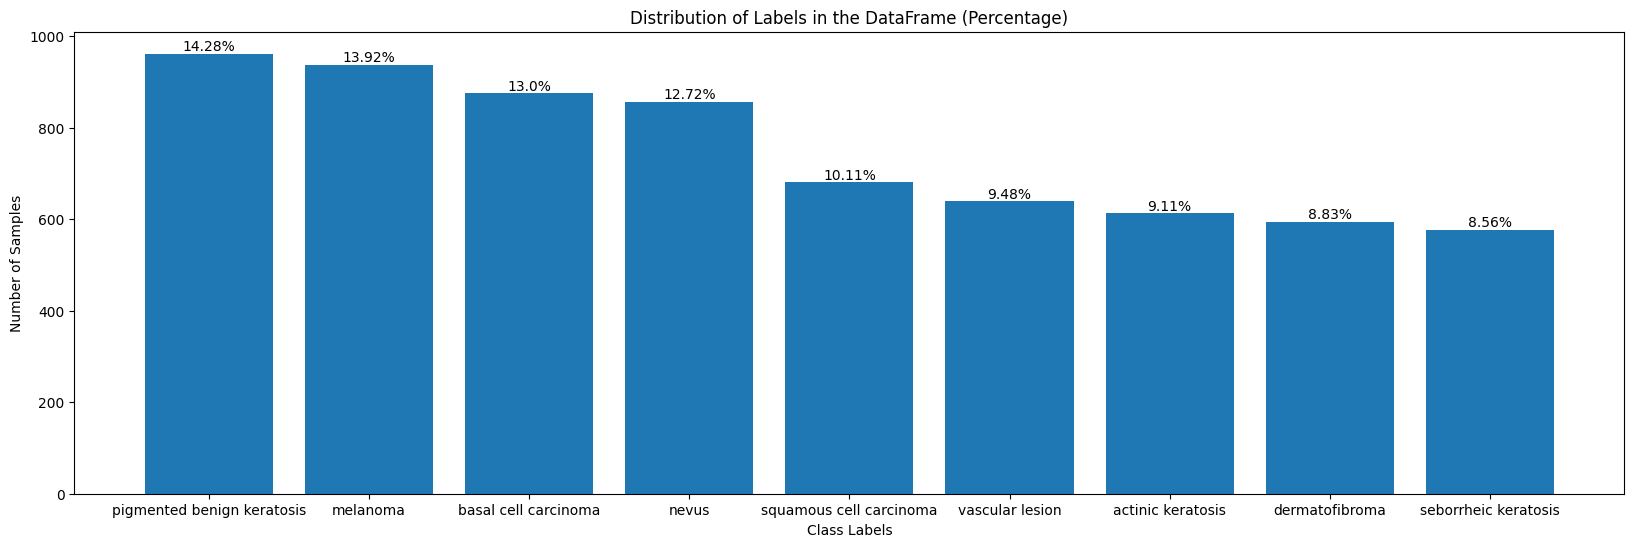

In [35]:
label_counts = new_df['Label'].value_counts()
total_samples = len(new_df)

percentages = label_counts / total_samples * 100

plt.figure(figsize=(20, 6))
bars = plt.bar(label_counts.index, label_counts)

# Annotating each bar with the percentage value
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{round(percentage, 2)}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in the DataFrame (Percentage)')
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images when we want to improve training process.

# Model Building & Training
- After handling class imbalance using Augmentor & adding Normalisation

In [36]:
# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
              data_dir_train,
              seed = 123,
              validation_split = 0.2,
              subset = 'training',
              image_size = (img_height, img_width),
              batch_size = batch_size
            )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [37]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
          data_dir_train,
          seed=123,
          validation_split = 0.2,
          subset = 'validation',
          image_size = (img_height, img_width),
          batch_size = batch_size
        )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:
(train_ds_cached, val_ds_cached) = create_cached_ds(train_ds, val_ds)

In [45]:
model_norm = Sequential(
    [
      layers.experimental.preprocessing.Rescaling(1./255,
                                                  input_shape = (
                                                      img_height,
                                                      img_width,
                                                      3
                                                    )
                                                  ),

      Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),


      Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.25),

      Flatten(),
      Dense(1024, activation='relu'),
      Dropout(0.5),

      Dense(9, activation='softmax')
    ]
)

model_norm.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_12 (Ba  (None, 180, 180, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)       

In [46]:
model_norm.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [47]:
# The original notebook and project pipeline contradict each other with various number
# of epochs given. Going with 20 epochs as per the Evaluation Rubric
# (Note: the project pipeline asks for training for 30 epochs and some training
#        has been tested using this value, but the code below specifies the
#        Evaluation Rubric number.)

epochs = 20
model_norm_history = model_norm.fit(
  train_ds_cached,
  validation_data = val_ds_cached,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 12s 52ms/step - loss: 2.3478 - accuracy: 0.3496 - val_loss: 3.9161 - val_accuracy: 0.1403
Epoch 2/20
169/169 [==============================] - 9s 50ms/step - loss: 1.4783 - accuracy: 0.4523 - val_loss: 5.3084 - val_accuracy: 0.1581
Epoch 3/20
169/169 [==============================] - 9s 53ms/step - loss: 1.3633 - accuracy: 0.4928 - val_loss: 3.7773 - val_accuracy: 0.2138
Epoch 4/20
169/169 [==============================] - 8s 50ms/step - loss: 1.2398 - accuracy: 0.5302 - val_loss: 2.8669 - val_accuracy: 0.3215
Epoch 5/20
169/169 [==============================] - 9s 52ms/step - loss: 1.1438 - accuracy: 0.5697 - val_loss: 1.8881 - val_accuracy: 0.4321
Epoch 6/20
169/169 [==============================] - 8s 50ms/step - loss: 1.0405 - accuracy: 0.6111 - val_loss: 1.4589 - val_accuracy: 0.5071
Epoch 7/20
169/169 [==============================] - 9s 55ms/step - loss: 0.9704 - accuracy: 0.6324 - val_loss: 1.3761 - val_accuracy: 0.579

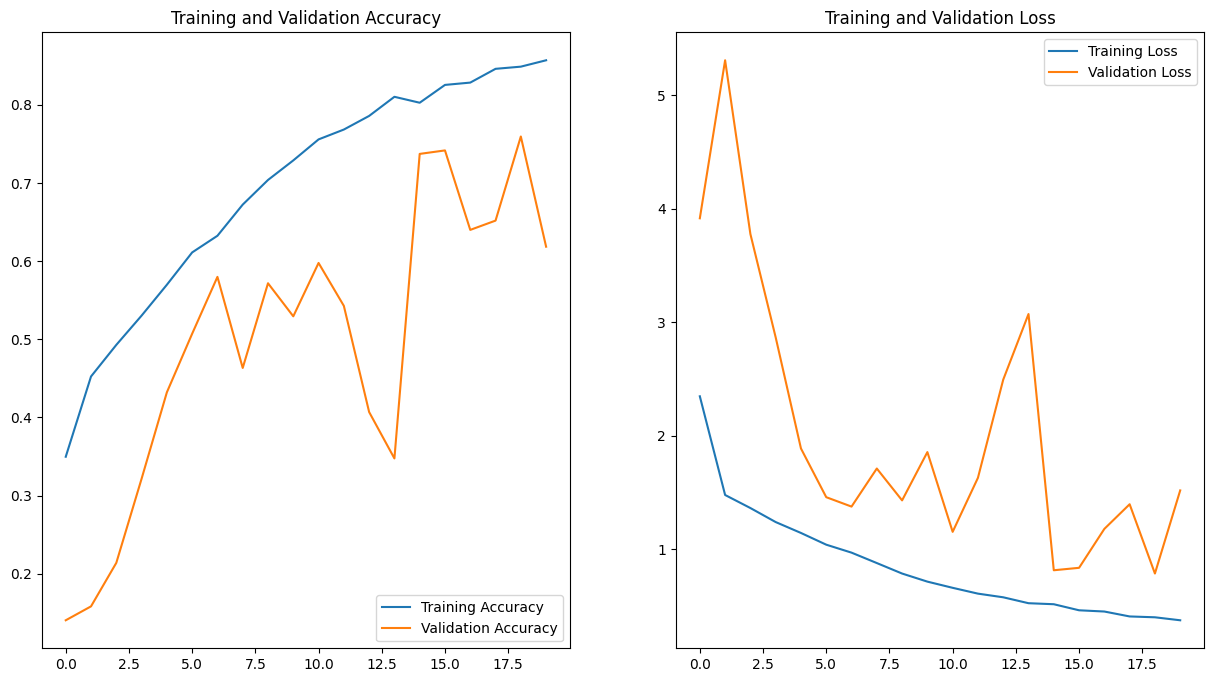

In [48]:
acc = model_norm_history.history['accuracy']
val_acc = model_norm_history.history['val_accuracy']

loss = model_norm_history.history['loss']
val_loss = model_norm_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The results after handling class imbalance have shown improvement over previous models, with training accuracy of ~0.86 at 20 epochs, and validation accuracy at ~0.61. Judging by the large fluctuations in the validation loss, it is recommended to rerun the training with a reducing learning rate. The model seems to be jumping around a local minimum.Possibly including a callback to reduce the learning rate once an accuracy of 0.8 has been reached may lead to improvements.

